# Transfer Learning with Pre-trained Models on CIFAR-100

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the CIFAR-100 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by CIFAR-100, which consists of 100 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the CIFAR-100 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of CIFAR-100.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the CIFAR-100 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on CIFAR-100.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

X_train_resnet50 = preprocess_resnet50(X_train)
X_test_resnet50 = preprocess_resnet50(X_test)

X_train_vgg16 = preprocess_vgg16(X_train)
X_test_vgg16 = preprocess_vgg16(X_test)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train)
X_test_mobilenetv2 = preprocess_mobilenetv2(X_test)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x) # output layer

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.2 Using VGG16

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.3 Using MobileNetV2

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-3794676327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [5]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(X_train_resnet50, y_train, epochs=epochs, validation_data=(X_test_resnet50, y_test))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(X_train_vgg16, y_train, epochs=epochs, validation_data=(X_test_vgg16, y_test))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_test))

178
22
157
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.2832 - loss: 3.0660 - val_accuracy: 0.3985 - val_loss: 2.3579
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4705 - loss: 1.9719 - val_accuracy: 0.4317 - val_loss: 2.2492
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5728 - loss: 1.5196 - val_accuracy: 0.4437 - val_loss: 2.3057
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.0633 - loss: 6.3867 - val_accuracy: 0.0563 - val_loss: 3.9696
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.0806 - loss: 3.7791 - val_accuracy: 0.1148 - val_loss: 3.5312
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1174 - loss: 3.4994 - val_accuracy: 0.1433 - val_loss: 3.3766
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.1343 - loss: 3.8148 - val_accuracy: 0.1093 - val_loss: 4.6462
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2632

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [ ]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_test)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_test)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_test)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4556 - loss: 2.3153
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3125 - loss: 2.6810
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2793 - loss: 3.1377
ResNet50 Accuracy: 0.45
VGG16 Accuracy: 0.31
MobileNetV2 Accuracy: 0.28


#### Key Observations
ResNet50 achieved the highest accuracy (45%), demonstrating stronger feature extraction and better generalization on CIFAR-100.

VGG16 showed moderate performance, but struggled with fine-grained classification across 100 classes.

MobileNetV2 had the lowest accuracy, likely due to its lightweight architecture prioritizing efficiency over representational capacity.

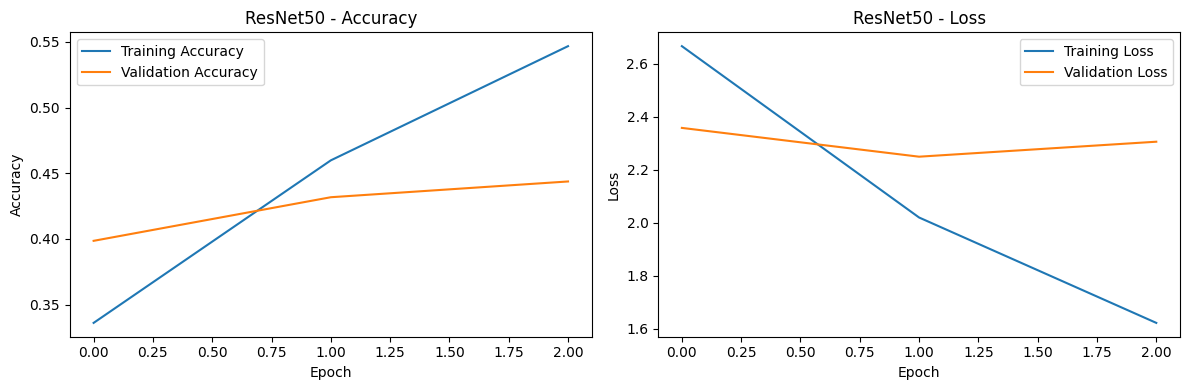

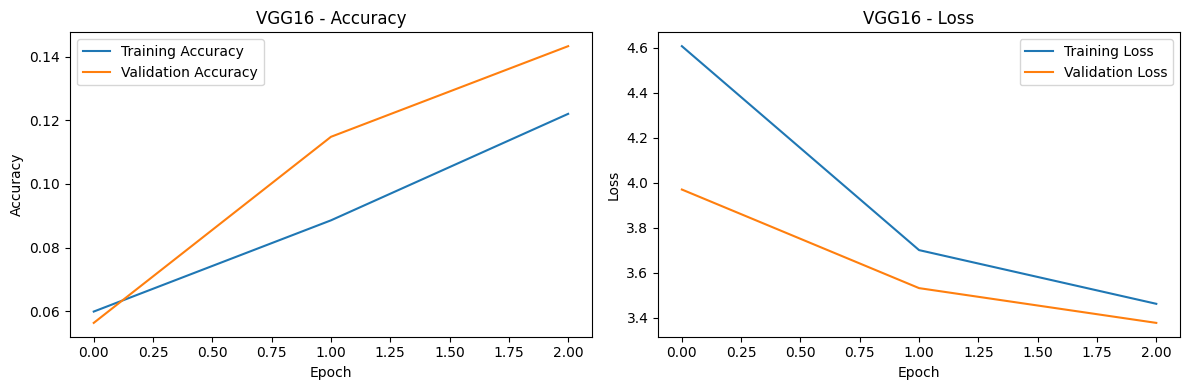

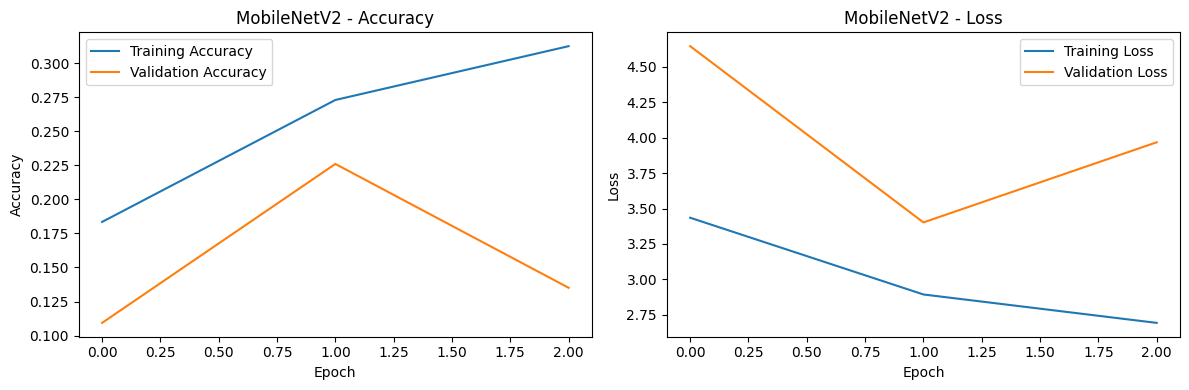

In [6]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

In [7]:
# Save the models
model_resnet50.save('resnet50_cifar100.h5')
model_vgg16.save('vgg16_cifar100.h5')
model_mobilenetv2.save('mobilenetv2_cifar100.h5')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the CIFAR-100 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

### Dowload Images for demo using github pages
link:

In [8]:
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import os

# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Create a folder to save test images
os.makedirs('cifar100_test_images', exist_ok=True)

# Save first 10 test images as PNG
for i in range(10):
    img = x_test[i]
    label = y_test[i][0]  # class index
    plt.imsave(f'cifar100_test_images/img_{i}_{label}.png', img)

In [9]:
cifar100_fine_labels = [
    'apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle',
    'bowl','boy','bridge','bus','butterfly','cattle','chair','chimpanzee','clock','cloud',
    'cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish',
    'forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower',
    'leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse',
    'mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree',
    'plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket',
    'rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel',
    'streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor',
    'train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm'
]
